In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
import numpy as np
import cv2
import os
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.optimizers import RMSprop, Adam
from keras.losses import binary_crossentropy 
from keras_preprocessing.image import ImageDataGenerator #for image preprocessing

Using TensorFlow backend.


In [2]:
sns.set_style('darkgrid')

In [3]:
train_data = r'C:\Users\fabio\Documents\DataSets\cell_images\train_base\train_data'
validation_data = r'C:\Users\fabio\Documents\DataSets\cell_images\train_base\validation_data'
test_data = r'C:\Users\fabio\Documents\DataSets\cell_images\test_data'

In [4]:
train_batch_size = 55
val_batch_size = 70
train_data_size = 12000
val_data_size = 10780
train_steps = int(train_data_size / train_batch_size)
val_steps = int(val_data_size / val_batch_size)

In [9]:
def display_samples(img_path, nrows=0, ncols=0, title='', figsize=(5, 5), color_space=None):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    for ax, image in zip(axes, img_path):
        img = cv2.imread(image)
        ax.imshow(cv2.cvtColor(img, color_space))
        ax.axis('off')
    fig.suptitle(title, fontsize=14)

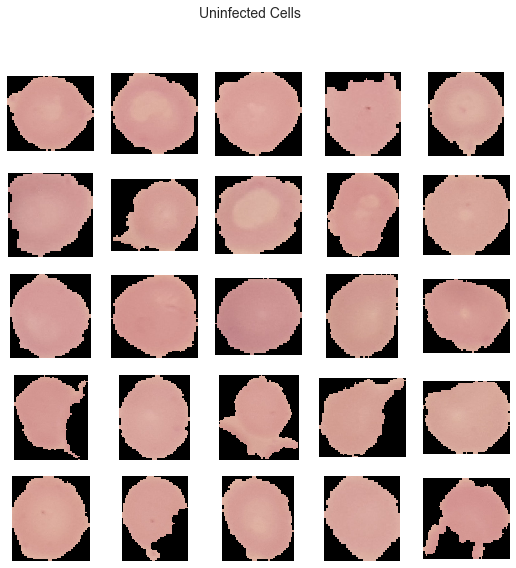

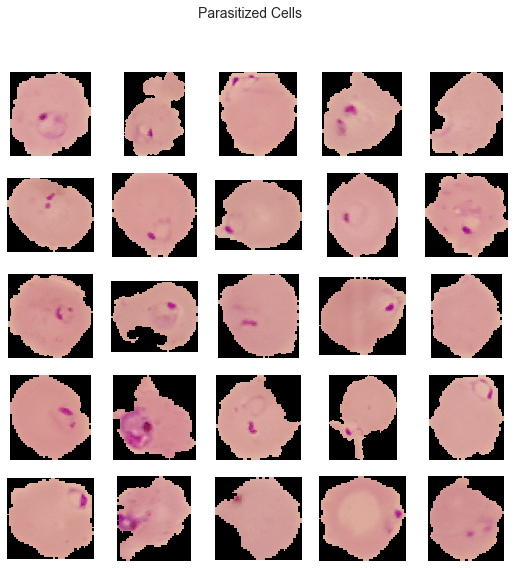

In [10]:
img_path_parasitized = r'C:\Users\fabio\Documents\DataSets\cell_images\train_base\train_data\train_parasitized'
img_path_uninfected = r'C:\Users\fabio\Documents\DataSets\cell_images\train_base\train_data\train_uninfected'
imgs_par = [os.path.join(img_path_parasitized, fname) for fname in os.listdir(img_path_parasitized)]
imgs_unin = [os.path.join(img_path_uninfected, fname) for fname in os.listdir(img_path_uninfected)]

display_samples(imgs_unin, 5, 5, title='Uninfected Cells', figsize=(9, 9), color_space=cv2.COLOR_BGR2RGB)
display_samples(imgs_par, 5, 5, title='Parasitized Cells', figsize=(9, 9), color_space=cv2.COLOR_BGR2RGB)

In [117]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    directory=train_data,
    target_size=(100, 100),
    class_mode='binary',
    batch_size=train_batch_size
)

Found 12000 images belonging to 2 classes.


In [118]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    directory=validation_data,
    target_size=(100, 100),
    batch_size=val_batch_size,
    class_mode='binary'
)

Found 10780 images belonging to 2 classes.


In [123]:
checkpoint = ModelCheckpoint(r'C:\Users\fabio\Documents\models\malaria_detection_model.h5',
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=False,
                            mode='auto')

earlystopping = EarlyStopping(patience=5, 
                              monitor='val_acc')

In [124]:
callback_list = [earlystopping, checkpoint]

In [128]:
model = Sequential([Conv2D(12, (5, 5), activation='relu', input_shape=(100, 100, 3)),
                    Conv2D(32, (3, 3), activation='relu'),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D(2, 2),
                    BatchNormalization(),
                    Conv2D(128, (3, 3), activation='relu'),
                    Conv2D(142, (1, 1), activation='relu'),
                    Conv2D(152, (1, 1), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(164, (1, 1), activation='relu'),
                    Conv2D(182, (1, 1), activation='relu'),
                    Conv2D(200, (1, 1), activation='relu'),
                    MaxPooling2D(2, 2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(200, activation='relu'),
                    Dense(1, activation='sigmoid')])

In [129]:
model.compile(loss=binary_crossentropy,
              optimizer=Adam(),
              metrics=['acc'])

In [130]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_steps,
                           epochs=15,
                           validation_steps=val_steps,
                           validation_data=validation_generator,
                           callbacks=callback_list,
                           )

Epoch 1/15
218/218 [==============================] - 126s 579ms/step - loss: 0.3806 - acc: 0.8303 - val_loss: 0.2374 - val_acc: 0.9339

Epoch 00001: val_acc improved from 0.90640 to 0.93386, saving model to C:\Users\fabio\Documents\models\malaria_detection_model.h5
Epoch 2/15
218/218 [==============================] - 119s 545ms/step - loss: 0.2191 - acc: 0.9214 - val_loss: 0.2986 - val_acc: 0.8660

Epoch 00002: val_acc did not improve from 0.93386
Epoch 3/15
218/218 [==============================] - 119s 548ms/step - loss: 0.2119 - acc: 0.9262 - val_loss: 0.2485 - val_acc: 0.9240

Epoch 00003: val_acc did not improve from 0.93386
Epoch 4/15
218/218 [==============================] - 119s 548ms/step - loss: 0.1972 - acc: 0.9319 - val_loss: 0.2953 - val_acc: 0.9382

Epoch 00004: val_acc improved from 0.93386 to 0.93822, saving model to C:\Users\fabio\Documents\models\malaria_detection_model.h5
Epoch 5/15
218/218 [==============================] - 119s 548ms/step - loss: 0.2106 - acc: 

In [131]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

epochs = range(1, 1 + len(train_loss))

In [132]:
def loss_val_curves(epochs=0.0, train_loss=0.0, val_loss=0.0, train_acc=0.0, val_acc=0.0):
    sns.set(rc={'figure.figsize' : (10, 5)})
    plt.subplot(1, 2, 1)
    sns.set_style('darkgrid')
    sns.lineplot(x=epochs, y=train_loss, color='blue', label='Train Loss')
    sns.lineplot(x=epochs, y=val_loss, color='red', label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=train_acc, color='blue', label='Train Acc')
    sns.lineplot(x=epochs, y=val_acc, color='red', label='Validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.show()

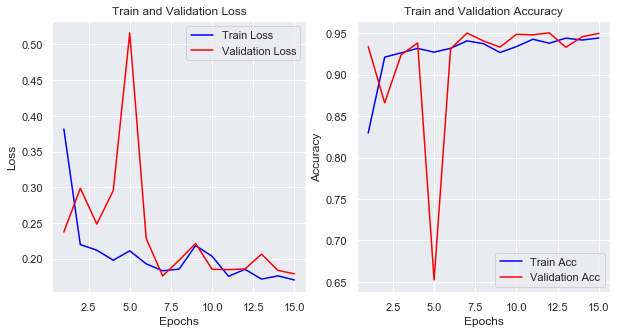

In [133]:
loss_val_curves(epochs, train_loss, val_loss, train_acc, val_acc)

In [ ]:
#Evaluates the model's accuracy on the test set.

In [134]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory=test_data,
                                                  target_size=(100, 100),
                                                  batch_size=1,
                                                  class_mode='binary',
                                                  shuffle=False,
                                                  color_mode='rgb'
                                                  )

Found 4778 images belonging to 2 classes.


In [135]:
test_samples = 4778 
probabilities = model.predict_generator(test_generator, steps=test_samples)

In [ ]:
class_map = {1 : 'Parasitized', 0 : 'Uninfected'}

In [136]:
ground_truth = test_generator.classes

In [138]:
def convert_to_class(probabilities):
    classes = []
    for i in probabilities:
        if i > 0.5:
            classes.append(1)
        else:
            classes.append(0)
    return np.array(classes)

In [139]:
from sklearn.metrics import accuracy_score
predictions = convert_to_class(probabilities)
print('Test Accuracy: %.2f' % accuracy_score(ground_truth, predictions))

Test Accuracy: 0.94


In [ ]:
from keras.models import load_model
loaded_model = load_model(r'C:\Users\fabio\Documents\models\malaria_detection_model.h5')

In [ ]:
probabilities = loaded_model.predict_generator(test_generator, steps=test_samples) #load the saved model.

In [ ]:
predictions = np.array(convert_to_class(probabilities))

In [ ]:
print('Test Accuracy: %.2f' % accuracy_score(ground_truth, predictions))